<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
def get_auc_lr_valid(X, y, C=1.0, ratio = 0.9, seed=17):
    '''
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    '''
    train_len = int(ratio * X.shape[0])
    X_train = X[:train_len, :]
    X_valid = X[train_len:, :]
    y_train = y[:train_len]
    y_valid = y[train_len:]
    
    logit = LogisticRegression(C=C, n_jobs=-1, random_state=seed)
    
    logit.fit(X_train, y_train)
    
    valid_pred = logit.predict_proba(X_valid)[:,1]
    
    return roc_auc_score(y_valid, valid_pred)

Reading original data

In [4]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [5]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [6]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


Separate target feature 

In [7]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

In [8]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [9]:
full_sites.shape

(336358, 10)

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [10]:
%%time
str_df = full_sites[sites]\
               .apply(lambda x: " ".join([str(a) for a in x.values if not a==0]), axis=1)

CPU times: user 9.76 s, sys: 47.4 ms, total: 9.81 s
Wall time: 9.81 s


In [11]:
str_df.head()

session_id
21669                                       56 55
54843                                 56 55 56 55
77292     946 946 951 946 946 945 948 784 949 946
114021    945 948 949 948 945 946 947 945 946 946
146670    947 950 948 947 950 952 946 951 946 947
dtype: object

In [12]:
%%time
full_sites_sparse = TfidfVectorizer(ngram_range=(1,3), 
                                    max_features=100000, token_pattern='(?u)\\b\\w+\\b').fit_transform(str_df)

CPU times: user 15.1 s, sys: 544 ms, total: 15.6 s
Wall time: 15.7 s


In [13]:
X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

In [14]:
full_sites_sparse.shape, X_train_sparse.shape, X_test_sparse.shape

((336358, 100000), (253561, 100000), (82797, 100000))

In [15]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_sparse, y_train)

CPU times: user 14.2 s, sys: 188 ms, total: 14.4 s
Wall time: 4.62 s


In [34]:
get_auc_lr_valid(X_train_sparse, y_train, ratio=0.8)

0.92729257732863013

In [17]:
test_pred = logit.predict_proba(X_test_sparse)[:,1]

In [18]:
write_to_submission_file(test_pred, 'n_gram1_3__max100k.csv')

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [19]:
new_feat_train = pd.DataFrame(index=train_df.index)
new_feat_test = pd.DataFrame(index=test_df.index) 

new_feat_train['year_month'] = train_df['time1'].apply(lambda ts: ts.year * 100 + ts.month)
new_feat_test['year_month'] = test_df['time1'].apply(lambda ts: ts.year * 100 + ts.month)

In [20]:
scaler = StandardScaler()
scaler.fit(new_feat_train['year_month'].values.reshape(-1,1))

new_feat_train['year_month_scaled'] = scaler.transform(new_feat_train['year_month'].values.reshape(-1,1))
new_feat_test['year_month_scaled'] = scaler.transform(new_feat_test['year_month'].values.reshape(-1,1))

In [21]:
new_feat_train.head()

,year_month,year_month_scaled
session_id,,
21669,201301,-1.744405
54843,201301,-1.744405
77292,201301,-1.744405
114021,201301,-1.744405
146670,201301,-1.744405


In [22]:
# Создаем признак start_hour:
new_feat_train['start_hour'] = train_df['time1'].apply(lambda ts: ts.hour)
new_feat_test['start_hour'] = test_df['time1'].apply(lambda ts: ts.hour)

In [23]:
scaler = StandardScaler()
scaler.fit(new_feat_train['start_hour'].values.reshape(-1,1))

new_feat_train['start_hour_scaled'] = scaler.transform(new_feat_train['start_hour'].values.reshape(-1,1))
new_feat_test['start_hour_scaled'] = scaler.transform(new_feat_test['start_hour'].values.reshape(-1,1))

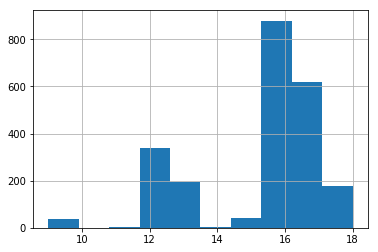

In [24]:
new_feat_train['start_hour'][y_train==1].hist();

In [25]:
# Создаем признаки morning:
new_feat_train['morning'] = new_feat_train['start_hour'].apply(lambda x: 1 if x<=11 else 0)
new_feat_test['morning'] = new_feat_test['start_hour'].apply(lambda x: 1 if x<=11 else 0)

In [26]:
new_feat_train.head()

,year_month,year_month_scaled,start_hour,start_hour_scaled,morning
session_id,,,,,
21669,201301,-1.744405,8,-1.357366,1
54843,201301,-1.744405,8,-1.357366,1
77292,201301,-1.744405,8,-1.357366,1
114021,201301,-1.744405,8,-1.357366,1
146670,201301,-1.744405,8,-1.357366,1


In [27]:
years = ['%s' % i for i in set(new_feat_train['year_month_scaled'].values)]
years
#pd.get_dummies(new_feat_train['year_month_scaled'])

['0.610964510523',
 '0.634518205271',
 '0.658071900018',
 '0.681625594766',
 '-1.74440496425',
 '-1.62663649052',
 '-1.60308279577',
 '-1.57952910102',
 '-1.55597540627',
 '-1.50886801678',
 '-1.65019018526',
 '-1.69729757476',
 '-1.72085126951',
 '-1.48531432203',
 '-1.53242171152',
 '-1.67374388001']

In [28]:
X_train = csr_matrix(hstack([X_train_sparse,
                            new_feat_train[['year_month_scaled', 'start_hour_scaled', 'morning']].values.reshape(-1,3)]))

X_test = csr_matrix(hstack([X_test_sparse,
                            new_feat_test[['year_month_scaled', 'start_hour_scaled', 'morning']].values.reshape(-1,3)]))

In [29]:
X_train.shape, X_test.shape

((253561, 100003), (82797, 100003))

In [30]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train, y_train)

CPU times: user 14.9 s, sys: 196 ms, total: 15.1 s
Wall time: 3.86 s


In [35]:
get_auc_lr_valid(X_train, y_train, ratio=0.8)

0.96568781301229523

In [32]:
test_pred = logit.predict_proba(X_test)[:,1]

In [33]:
write_to_submission_file(test_pred, 'n_gram1_3__max100k__3feat.csv')